# Classifier model

This notebook deals with finding a classifier model to classify a given image into a correct class. Therefor I will evaluate different approaches.

## Setup and general preparation


In [40]:
# Imports
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchsummary import summary
from utils import DEVICE, classes, train_data, test_data, BaseModule # type: ignore
import import_ipynb
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# Global variables

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
PATIENCE = 3

# Data loaders
TRAIN_LOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6)
TEST_LOADER = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

# Loss functions
TRAIN_CRITERION = nn.CrossEntropyLoss() # CrossEntropyLoss combines log-softmax + NLLLoss
TEST_CRITERION = nn.CrossEntropyLoss(reduction='sum') # For test function

# LR scheduler lambda function
def lr_lambda(epoch):
    if epoch < 5:
        return (epoch + 1) / 5
    else:
        return 0.95 ** (epoch - 5)

### Training, Validation and Evaluation Workflow

In order to compare different models to each other faster, I wrote central train, test and evaluation functions. This way I'm able to just create a bunch of different models and compare them easily. 

For evaluation I choose the following metrics:

| Metric               | Formula                               | Description                                                                                    | 
|----------------------|---------------------------------------|------------------------------------------------------------------------------------------------|
| `Accuracy`           | Overall correct predictions} / total  | How well the model performs in general.                                                        |
| `Precision`          | TP / (TP + FP)                        | How many of the images predicted to be in a class are actually that class.                     |
| `Recall`             | TP / (TP + FN)                        | How many of the images in a class did the model classify correctly.                            |
| `F1-score`           | Harmonic mean of precision and recall | Balances precision and recall, shows how well the model doing on each class overall            |                  
| `Confusion Matrix`   | -                                     | Shows precisely what image as been classified as which class in comparison to the ground truth |

By employing other metrics than just the accuracy I'm able to get a more detailed and classwise view of model. Even though the classes are balanced maybe the model can't distinguish between to particular classes. This could then fixed by penalizing the false classifications more, or oversampling these images with some additional transforms.


In [ ]:
# One Epoch train function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for data, targets in dataloader:
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        logits = model(data)

        # We use CrossEntropyLoss which combines softmax and NLLLoss
        loss = criterion(logits, targets)

        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * data.size(0)

        # Calculate accuracy
        _, preds = logits.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# One Epoch test function
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            logits = model(data)
            loss = criterion(logits, targets)

            running_loss += loss.item() * data.size(0)
            _, preds = logits.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = running_loss / total
    accuracy = correct / total

    # Generate classification report, which includes precision, recall, and F1-score -> take the macro averaged ones
    report = classification_report(all_targets, all_preds, zero_division=0.0, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    return avg_loss, accuracy, precision, recall, f1

# Training loop for one model
def run_training_for_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=10,
    model_name='model'
):
    # Save the metrics history for plotting later
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_prec': [],
        'val_rec': [],
        'val_f1': [],
    }

    # Params for early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Start training {model_name}")

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_prec, val_rec, val_f1 = test(model, test_loader, criterion, device)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1} for model {model_name}")
            break

        scheduler.step()

        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)
        history['val_f1'].append(val_f1)

        print(f"Epoch {epoch+1} | Learning Rate {optimizer.param_groups[0]['lr']:.4f}\n"
            "Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {train_acc:.4f} | Val F1: {val_f1:.4f}")

    print(f"Training model {model_name} complete!")

    # Return history for evaluation and plotting
    return history

# Plotting metric history for all models
def plot_training_history(results):

    # Use a different color cycle for each model
    colors = plt.colormaps['tab10'].colors
    line_styles = ['-', '--', '-.', ':']
    color_cycle = itertools.cycle(colors)
    style_cycle = itertools.cycle(line_styles)

    num_models = len(results)
    model_names = list(results.keys())

    # Reset for consistent color/style per model
    model_styles = {}
    for name in model_names:
        model_styles[name] = {
            "color": next(color_cycle),
            "style": next(style_cycle)
        }

    # Create plot grid: 4 rows x 2 columns
    fig, axs = plt.subplots(4, 2, figsize=(16, 20))
    axs = axs.flatten()

    # Metrics and their subplot indices
    metric_info = {
        'train_loss': (0, 'Training Loss'),
        'train_acc':  (1, 'Training Accuracy'),
        'val_loss':   (2, 'Validation Loss'),
        'val_acc':    (3, 'Validation Accuracy'),
        'val_prec':   (4, 'Validation Precision'),
        'val_rec':    (5, 'Validation Recall'),
        'val_f1':     (6, 'Validation F1 Score'),
    }

    for metric, (idx, title) in metric_info.items():
        ax = axs[idx]
        for name, history in results.items():
            color = model_styles[name]["color"]
            style = model_styles[name]["style"]
            ax.plot(history[metric], label=name, color=color, linestyle=style)

        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend()

    # Hide the unused 8th subplot
    axs[7].axis('off')

    plt.tight_layout()
    plt.show()

# TODO: plot confusion matrix

# Main evaluation function to run the training and evaluation
def evaluate_models(models):

    results = {name: None for name in models.keys()}

    for name, model in models.items():
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

        history = run_training_for_model(
            model=model,
            train_loader=TRAIN_LOADER,
            test_loader=TEST_LOADER,
            criterion=TRAIN_CRITERION,
            optimizer=optimizer,
            scheduler=scheduler,
            device=DEVICE,
            num_epochs=NUM_EPOCHS,
            model_name=name
        )

        results[name] = history

    # Plot the training history for all models
    plot_training_history(results)

# Helper function to print model summary
def print_model_summary(models_dict):
    for model in models_dict.values():
        summary(model, input_size=(1, 28, 28))


### CNN

Since the dataset is very similar to the MNIST dataset I first want to explore training a CNN from scratch to get a baseline for the performance.

Moreover I found this kaggle notebook that evaluated some choices regarding the CNN architecture. In the following I will try to replicate these experiments on this dataset.

Reference:
 - [Kaggle Notebook](https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist)

#### Test 1: Amount of Convolution + Pooling Layers

Based on the referenced notebook I want to check how many of these layer combinations produce the best output. More layers would result in very small images that will likely not contain any valuable features

In [47]:
# Build the three CNN models
nets = 3
cnn_conv_layer_models = {f'CNN_{n + 1}_Conv': BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_conv_layer_models.values()):

    # First Convolutional Layer (in every model)
    model.layers.append(nn.Conv2d(1, 24, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    if i > 0:
        # Second Convolutional Layer (in every model except the first)
        model.layers.append(nn.Conv2d(24, 48, kernel_size=5, padding='same'))
        model.layers.append(nn.LeakyReLU())
        model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Third Convolutional Layer (only in the third model)
        if i == 2:
            model.layers.append(nn.Conv2d(48, 64, kernel_size=5, padding='same'))
            model.layers.append(nn.LeakyReLU())
            model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    # Output sizes after convolutional layers
    # 28x28 -> 14x14 -> 7x7 -> 3x3
    # 24*14*14 -> 48*7*7 -> 64*3*3
    conv_out = [24*14*14, 48*7*7, 64*3*3]

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(conv_out[i], 256))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Linear(256, 5))

print_model_summary(cnn_conv_layer_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             624
         LeakyReLU-2           [-1, 24, 28, 28]               0
         MaxPool2d-3           [-1, 24, 14, 14]               0
           Flatten-4                 [-1, 4704]               0
            Linear-5                  [-1, 256]       1,204,480
         LeakyReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 5]           1,285
Total params: 1,206,389
Trainable params: 1,206,389
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 4.60
Estimated Total Size (MB): 4.97
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Ou

Start training CNN_1_Conv
Epoch 1 | Learning Rate 0.0004 
             Train Loss: 0.3326 | Train Acc: 0.8932 | Val Acc: 0.8932 | Val F1: 0.9218
Epoch 2 | Learning Rate 0.0006 
             Train Loss: 0.3097 | Train Acc: 0.8998 | Val Acc: 0.8998 | Val F1: 0.9249
Training model CNN_1_Conv complete!
Start training CNN_2_Conv
Epoch 1 | Learning Rate 0.0004 
             Train Loss: 0.2563 | Train Acc: 0.9172 | Val Acc: 0.9172 | Val F1: 0.9373
Epoch 2 | Learning Rate 0.0006 
             Train Loss: 0.2374 | Train Acc: 0.9222 | Val Acc: 0.9222 | Val F1: 0.9440
Training model CNN_2_Conv complete!
Start training CNN_3_Conv
Epoch 1 | Learning Rate 0.0004 
             Train Loss: 0.2401 | Train Acc: 0.9212 | Val Acc: 0.9212 | Val F1: 0.9356
Epoch 2 | Learning Rate 0.0006 
             Train Loss: 0.2159 | Train Acc: 0.9270 | Val Acc: 0.9270 | Val F1: 0.9419
Training model CNN_3_Conv complete!


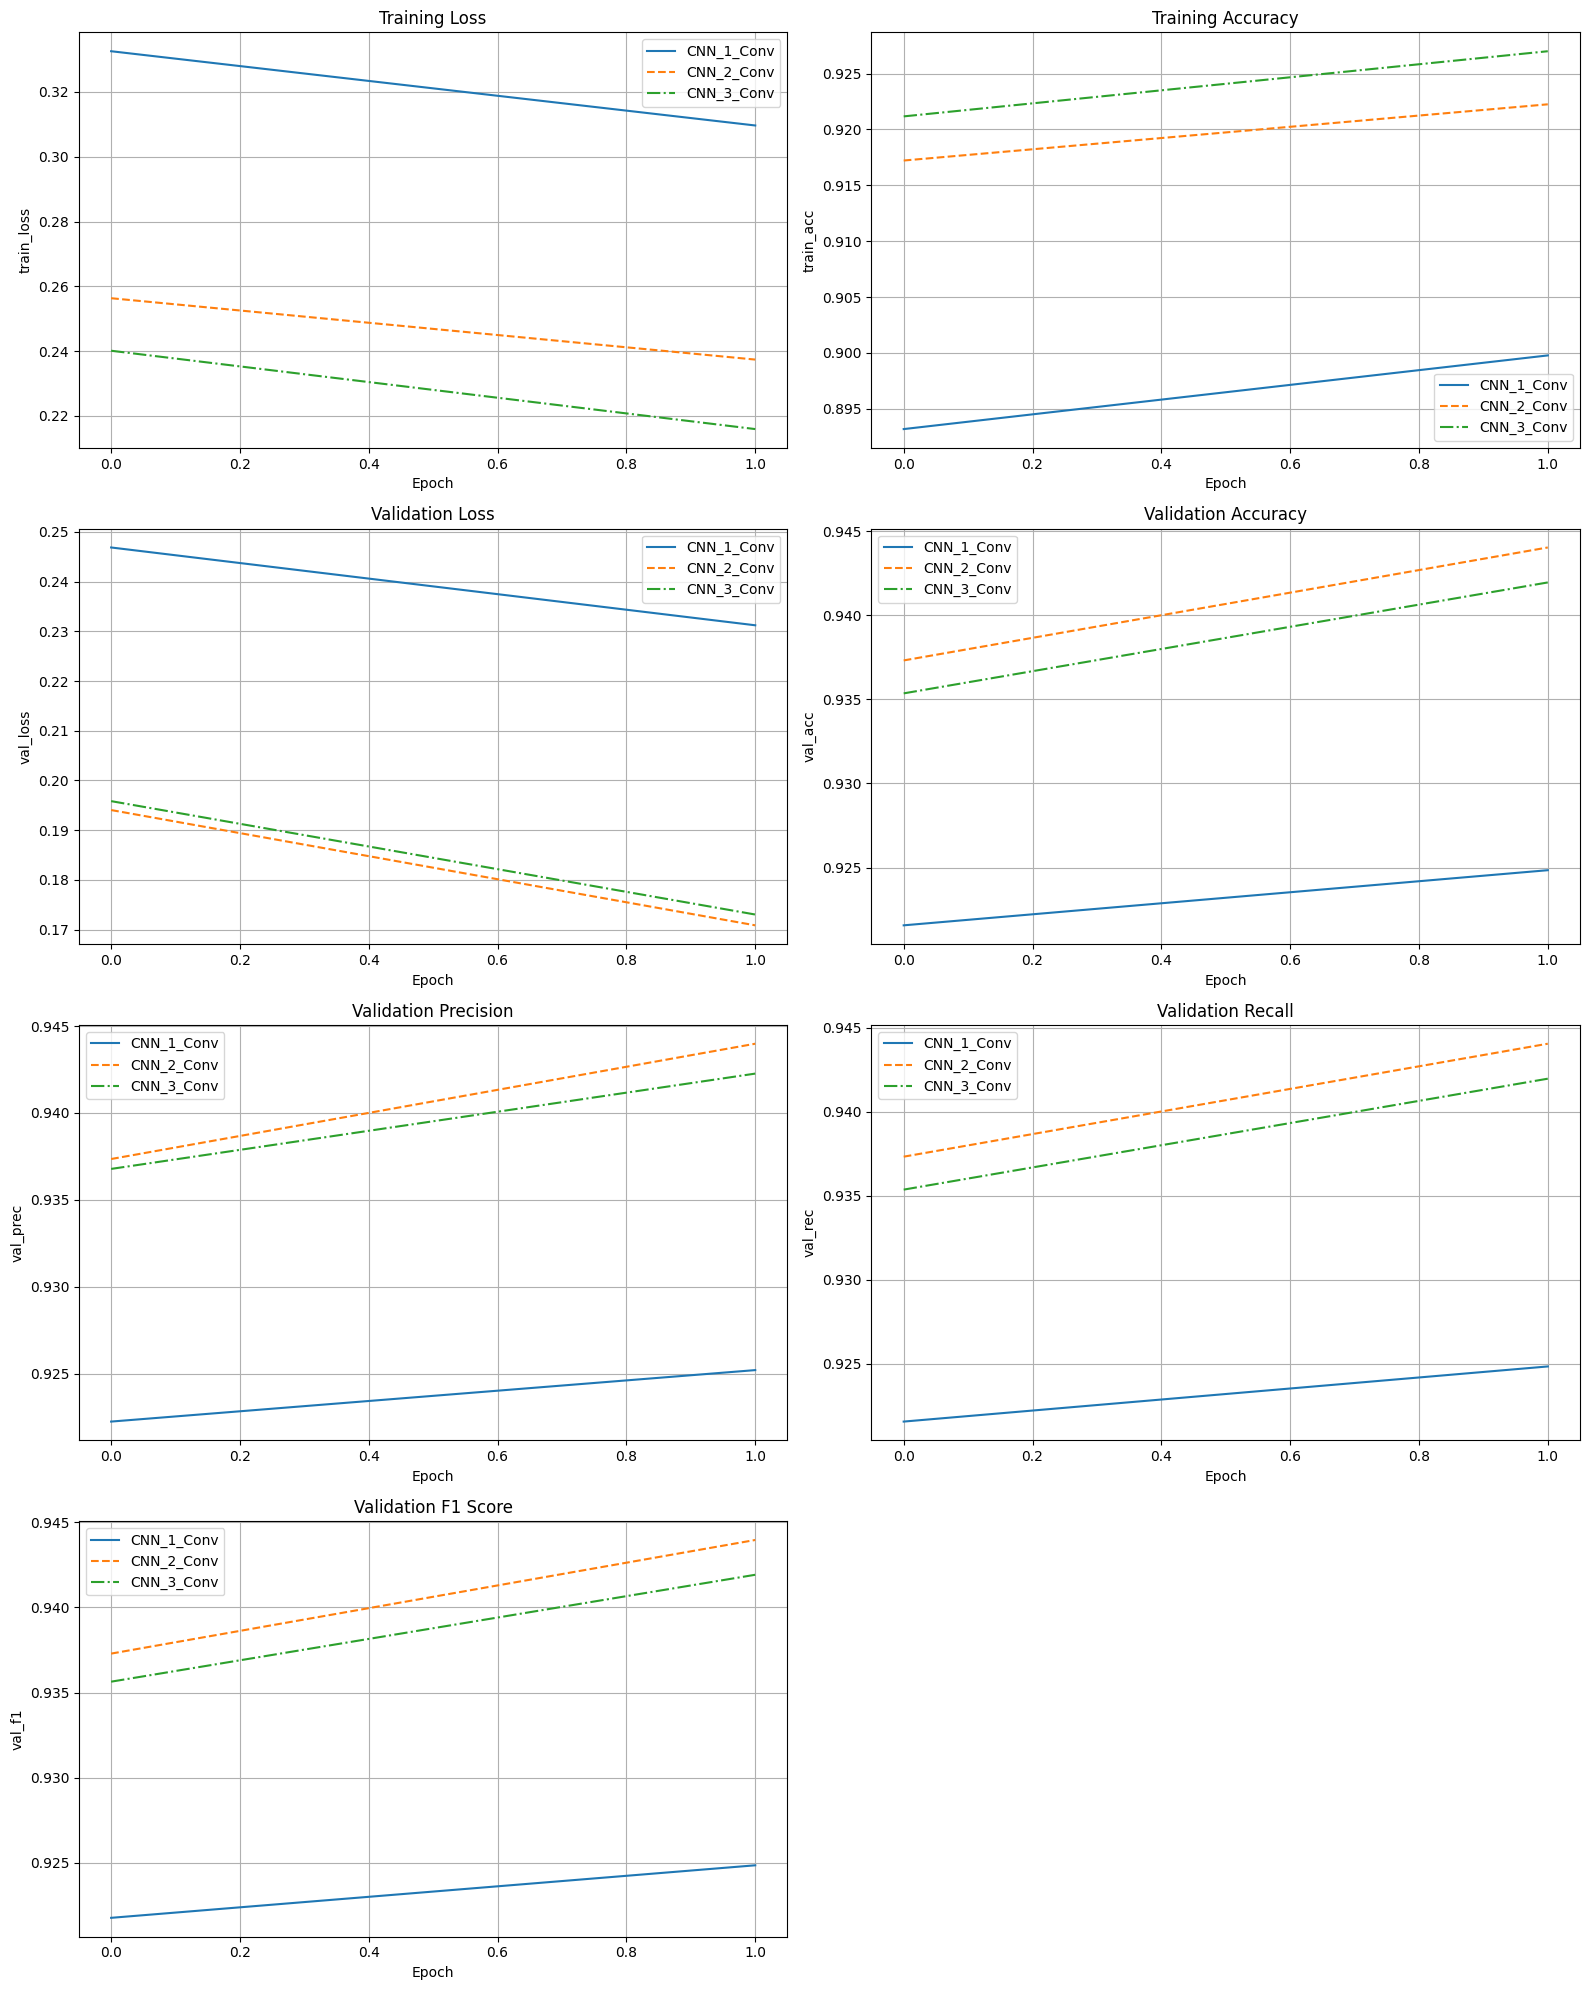

In [49]:
# Evaluate the number of convolutional layers
evaluate_models(cnn_conv_layer_models)

In [ ]:
nets = 6
cnn_num_kernels_models = [BaseModule() for _ in range(nets)]
for i in range(nets):
    cnn_num_kernels_models[i].layers.append(nn.Conv2d(1, i*8+8, kernel_size=5, padding='same'))
    cnn_num_kernels_models[i].layers.append(nn.LeakyReLU())
    cnn_num_kernels_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    cnn_num_kernels_models[i].layers.append(nn.Conv2d(i*8+8, i*16+16, kernel_size=5, padding='same'))
    cnn_num_kernels_models[i].layers.append(nn.LeakyReLU())
    cnn_num_kernels_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    cnn_num_kernels_models[i].layers.append(nn.Flatten())
    cnn_num_kernels_models[i].layers.append(nn.Linear((i*16+16)*7*7, 256))
    cnn_num_kernels_models[i].layers.append(nn.LeakyReLU())
    cnn_num_kernels_models[i].layers.append(nn.Linear(256, 5))

# Print models
for i in range(nets):
    summary(cnn_num_kernels_models[i], input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
         LeakyReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           3,216
         LeakyReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
           Flatten-7                  [-1, 784]               0
            Linear-8                  [-1, 256]         200,960
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 5]           1,285
Total params: 205,669
Trainable params: 205,669
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.78
Estimated T

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# DataLoader
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=6)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=6)

# Training
train_criterion = nn.CrossEntropyLoss() # CrossEntropyLoss combines log-softmax + NLLLoss
test_criterion = nn.CrossEntropyLoss(reduction='sum') # For test function

for i in range(nets):
    print(f"Training model with {i*8+8} and {i*16+16} kernels")
    model = cnn_num_kernels_models[i].to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)
    trainLoss = []
    testLoss = []
    testAcc = []

    for epoch in range(1, num_epochs + 1):
        trainLoss.append(train(model, device, train_loader, train_criterion, optimizer, epoch).item())
        t,a = test(model, device, test_loader, test_criterion)
        testLoss.append(t)
        testAcc.append(a)
        scheduler.step()

Training model with 8 and 16 kernels
Train Epoch: 1 [0/75000 (0%)] Loss: 0.333955
Train Epoch: 1 [6400/75000 (9%)] Loss: 0.344451
Train Epoch: 1 [12800/75000 (17%)] Loss: 0.098977
Train Epoch: 1 [19200/75000 (26%)] Loss: 0.232188
Train Epoch: 1 [25600/75000 (34%)] Loss: 0.220662
Train Epoch: 1 [32000/75000 (43%)] Loss: 0.130773
Train Epoch: 1 [38400/75000 (51%)] Loss: 0.267109
Train Epoch: 1 [44800/75000 (60%)] Loss: 0.113791
Train Epoch: 1 [51200/75000 (68%)] Loss: 0.269854
Train Epoch: 1 [57600/75000 (77%)] Loss: 0.093394
Train Epoch: 1 [64000/75000 (85%)] Loss: 0.152315
Train Epoch: 1 [70400/75000 (94%)] Loss: 0.209864

Test set: Average loss: 0.1552, Accuracy: 23685/25000 (95%)

Train Epoch: 2 [0/75000 (0%)] Loss: 0.308205
Train Epoch: 2 [6400/75000 (9%)] Loss: 0.399003
Train Epoch: 2 [12800/75000 (17%)] Loss: 0.205928
Train Epoch: 2 [19200/75000 (26%)] Loss: 0.154390
Train Epoch: 2 [25600/75000 (34%)] Loss: 0.236444
Train Epoch: 2 [32000/75000 (43%)] Loss: 0.232380
Train Epoch: 2 

KeyboardInterrupt: 

In [8]:
nets = 2
cnn_num_dense_layer_models = [BaseModule() for _ in range(nets)]

for i in range(nets):
    cnn_num_dense_layer_models[i].layers.append(nn.Conv2d(1, 32, kernel_size=5, padding='same'))
    cnn_num_dense_layer_models[i].layers.append(nn.LeakyReLU())
    cnn_num_dense_layer_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    cnn_num_dense_layer_models[i].layers.append(nn.Conv2d(32, 64, kernel_size=5, padding='same'))
    cnn_num_dense_layer_models[i].layers.append(nn.LeakyReLU())
    cnn_num_dense_layer_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    cnn_num_dense_layer_models[i].layers.append(nn.Flatten())
    cnn_num_dense_layer_models[i].layers.append(nn.Linear(64*7*7, 256))
    cnn_num_dense_layer_models[i].layers.append(nn.LeakyReLU())

    if i == 0:
        cnn_num_dense_layer_models[i].layers.append(nn.Linear(256, 5))
    else:
        cnn_num_dense_layer_models[i].layers.append(nn.Linear(256, 128))
        cnn_num_dense_layer_models[i].layers.append(nn.LeakyReLU())
        cnn_num_dense_layer_models[i].layers.append(nn.Linear(128, 5))

# Print models
for i in range(nets):
    summary(cnn_num_dense_layer_models[i], input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         LeakyReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
         LeakyReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 256]         803,072
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 5]           1,285
Total params: 856,453
Trainable params: 856,453
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 3.27
Estimated T

In [9]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# DataLoader
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=6)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=6)

# Training
train_criterion = nn.CrossEntropyLoss() # CrossEntropyLoss combines log-softmax + NLLLoss
test_criterion = nn.CrossEntropyLoss(reduction='sum') # For test function

for i in range(nets):
    print(f"Training model with {i+1} dense layers")
    model = cnn_num_dense_layer_models[i].to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)
    trainLoss = []
    testLoss = []
    testAcc = []

    for epoch in range(1, num_epochs + 1):
        trainLoss.append(train(model, device, train_loader, train_criterion, optimizer, epoch).item())
        t,a = test(model, device, test_loader, test_criterion)
        testLoss.append(t)
        testAcc.append(a)
        scheduler.step()

Training model with 1 dense layers
Train Epoch: 1 [0/75000 (0%)] Loss: 1.613632
Train Epoch: 1 [6400/75000 (9%)] Loss: 0.477903
Train Epoch: 1 [12800/75000 (17%)] Loss: 0.424915
Train Epoch: 1 [19200/75000 (26%)] Loss: 0.404655
Train Epoch: 1 [25600/75000 (34%)] Loss: 0.364250
Train Epoch: 1 [32000/75000 (43%)] Loss: 0.391702
Train Epoch: 1 [38400/75000 (51%)] Loss: 0.446629
Train Epoch: 1 [44800/75000 (60%)] Loss: 0.213461
Train Epoch: 1 [51200/75000 (68%)] Loss: 0.285810
Train Epoch: 1 [57600/75000 (77%)] Loss: 0.225441
Train Epoch: 1 [64000/75000 (85%)] Loss: 0.160558
Train Epoch: 1 [70400/75000 (94%)] Loss: 0.143415

Test set: Average loss: 0.2036, Accuracy: 23334/25000 (93%)

Train Epoch: 2 [0/75000 (0%)] Loss: 0.147010
Train Epoch: 2 [6400/75000 (9%)] Loss: 0.194148
Train Epoch: 2 [12800/75000 (17%)] Loss: 0.317836
Train Epoch: 2 [19200/75000 (26%)] Loss: 0.101981
Train Epoch: 2 [25600/75000 (34%)] Loss: 0.195652
Train Epoch: 2 [32000/75000 (43%)] Loss: 0.324563
Train Epoch: 2 [3

KeyboardInterrupt: 